In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

2022-12-08 12:37:54.818867: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [7]:
import dask.dataframe as ddf
import cudf
import cupy as cp

In [9]:
from feather_io import FeatherReader
data_reader = FeatherReader("acceptance-test")
test_dataset = data_reader.as_dask_dataframe()

In [10]:
import pickle
import os.path
preprocessing_file = "/workarea/cloud-storage/anderlinil/models/acceptance/tX.pkl"
with open(preprocessing_file, 'rb') as f:
    preprocessing_step = pickle.load(f)

In [11]:
acceptance_model = tf.keras.models.load_model("/workarea/cloud-storage/anderlinil/models/acceptance")
acceptance_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 51,073
Trainable params: 51,073
Non-trainable params: 0
_________________________________________________________________


In [12]:
def invert_column_transformer(column_transformer, preprocessed_X):
    preprocessed_split = {name: [None]*len(cols) for name, _, cols in column_transformer.transformers_}
        
    for iCol in range(preprocessed_X.shape[1]):
        name, transformer, cols = [(n, t, c) for n, t, c in column_transformer.transformers_ if iCol in c].pop()
        preprocessed_split[name][cols.index(iCol)] = preprocessed_X[:,iCol]
    
    X = []
    for name, algo, _ in column_transformer.transformers_:
        split = np.stack(preprocessed_split[name], axis=1)
        X.append(split if algo == 'passthrough' else algo.inverse_transform(split))
    
    return np.concatenate(X, axis=1)

In [15]:
#X, y = next(iter(test_dataset.as_numpy_iterator()))
#acceptance_vars = ["mc_x", "mc_y", "mc_z", "mc_p", "mc_px", "mc_py", "mc_is_e", "mc_is_mu", "mc_is_h", "mc_charge"]

def batch_to_df(batch, preprocessor, features, labels):
    preprocessed_X = batch[features].values
    y = batch[labels].values
    
    X = invert_column_transformer(preprocessor, preprocessed_X)

    y_hat = acceptance_model.predict(preprocessed_X, batch_size=len(X), verbose=False)
    df = pd.DataFrame(
        np.c_[X, y, y_hat],
        columns=['x',' y', 'z', 'log10_p', 'px', 'py', 'pz', 'is_e', 'is_mu', 'is_h', 'acceptance', 'predicted']
    )
    return df

from functools import partial
my_load_batch = partial(batch_to_df, 
                        features=data_reader.features, 
                        labels=data_reader.labels, 
                        preprocessor=preprocessing_step
                       )

## You may need to install dask-cudf
#mamba install -n base dask-cudf -y -c rapidsai -c conda-forge -c nvidia/label/cuda-11.7.0

cdf = (
    ddf
    .map_partitions(my_load_batch, test_dataset)
    .map_partitions(cudf.DataFrame.from_pandas)
)
cdf

INFO:tensorflow:Assets written to: ram://d16e8442-7180-4deb-96c2-996866f47f99/assets


,x,y,z,log10_p,px,py,pz,is_e,is_mu,is_h,acceptance,predicted
npartitions=5,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...


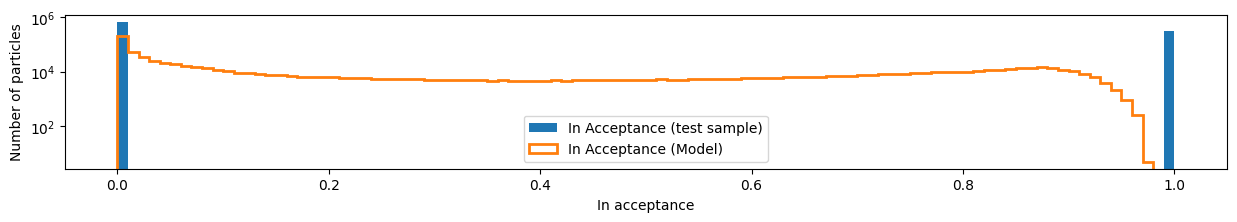

In [17]:
plt.figure(figsize=(15,2))
df = cdf.head(1_000_000, npartitions=-1)
plt.hist(df.acceptance, bins=np.linspace(0, 1, 101), label="In Acceptance (test sample)")
plt.hist(df.predicted, bins=np.linspace(0, 1, 101), label="In Acceptance (Model)", histtype='step', linewidth=2)
plt.legend()
plt.xlabel("In acceptance")
plt.ylabel("Number of particles")
plt.yscale('log')
plt.show()

In [18]:
def compute_eta(df):
    p = 10**df['log10_p']
    pt = (df.px**2 + df.py**2)**0.5
    theta = cp.arcsin(pt/p)
    df['eta'] = -cp.log(cp.tan(theta/2))
    return df

def compute_phi(df):
    df['phi'] = cp.arctan2(df.py, df.px)
    return df
    

cdf = (cdf.map_partitions(compute_eta)
          .map_partitions(compute_phi)
      )

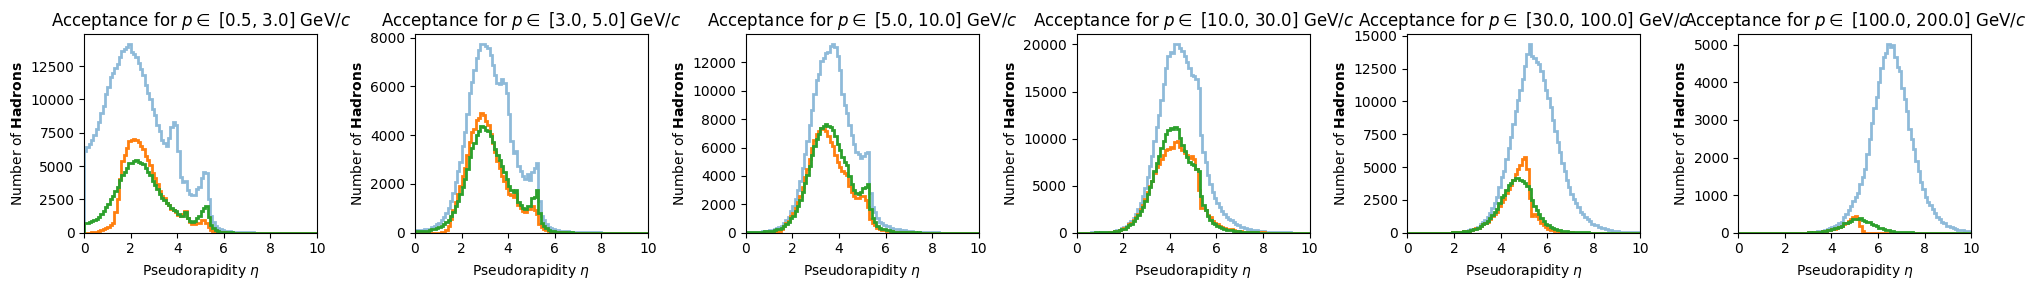

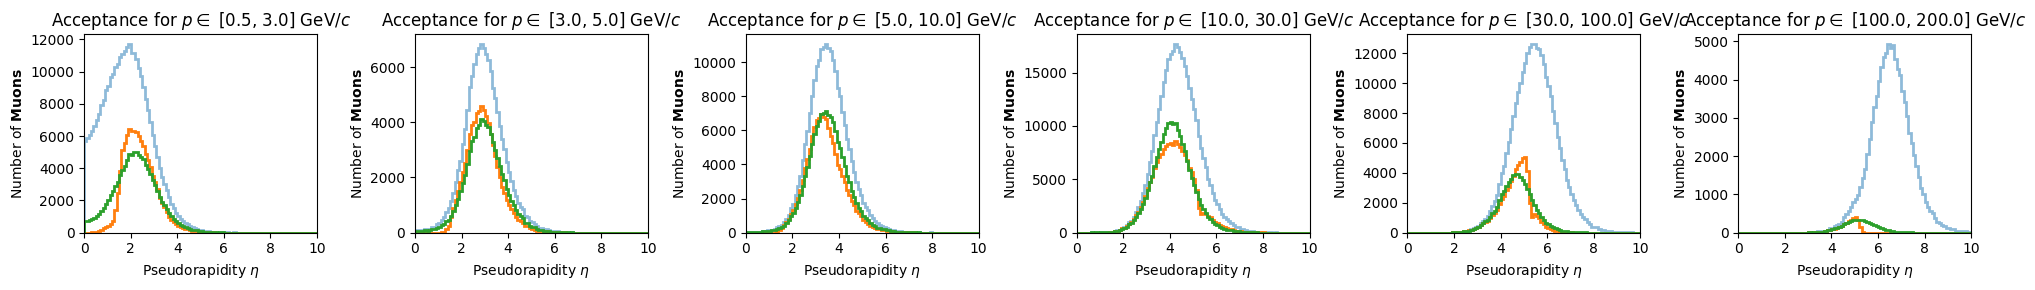

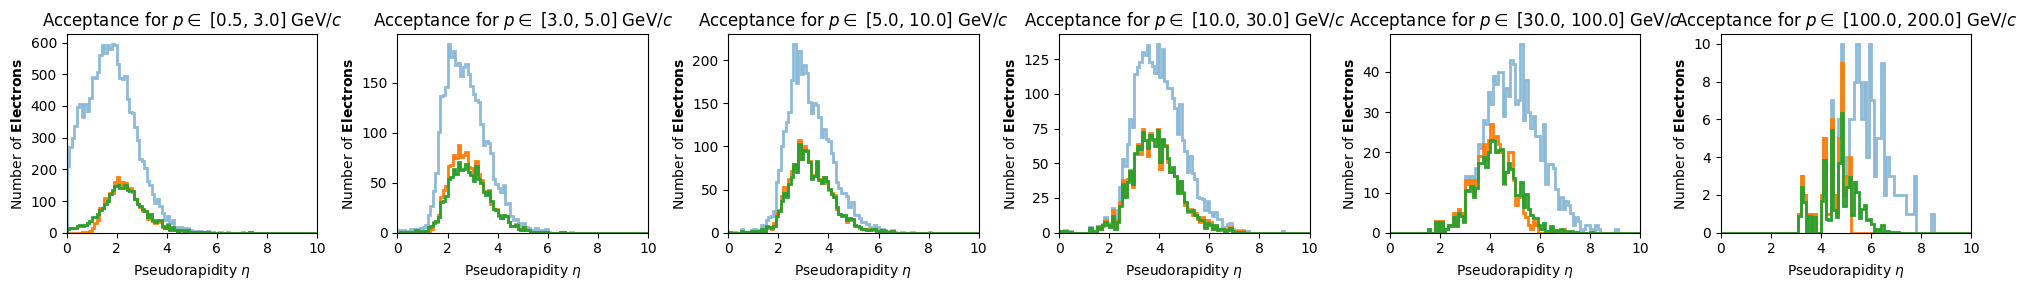

In [19]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"is_{part} and eta > 0 and eta < 12")[['acceptance', 'predicted', 'eta', 'log10_p']].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"log10_p > {np.log10(p_min)} and log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.eta.values, bins=np.linspace(0, 10, 101))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance').eta.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.eta.values, weights=bin_df.predicted.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Pseudorapidity $\eta$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()

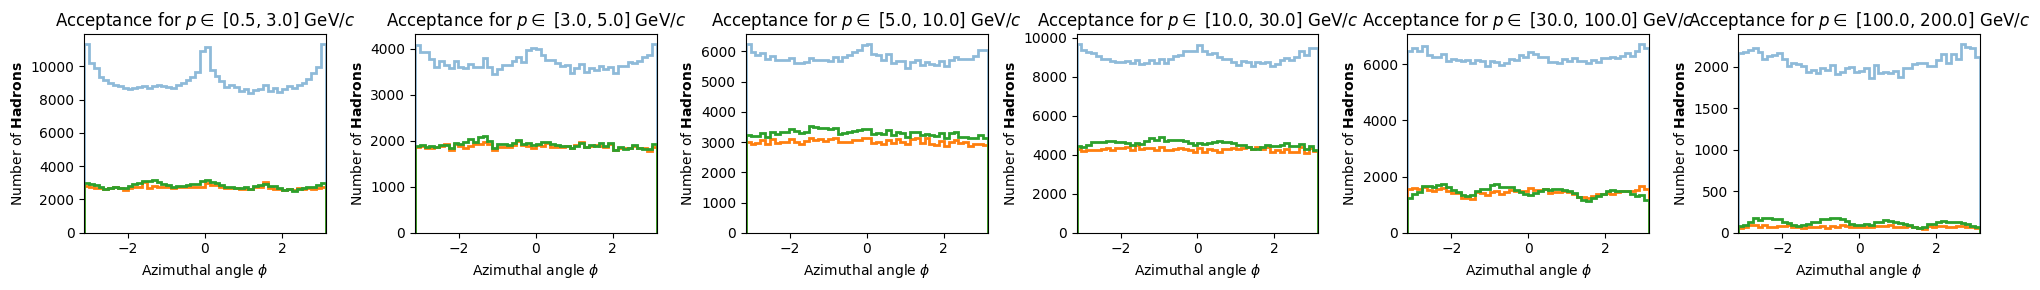

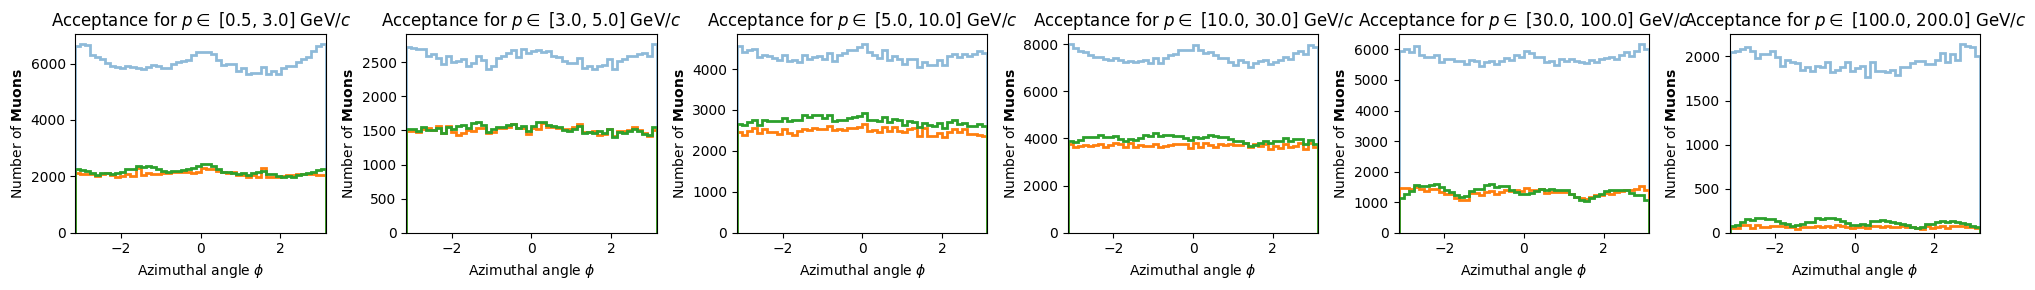

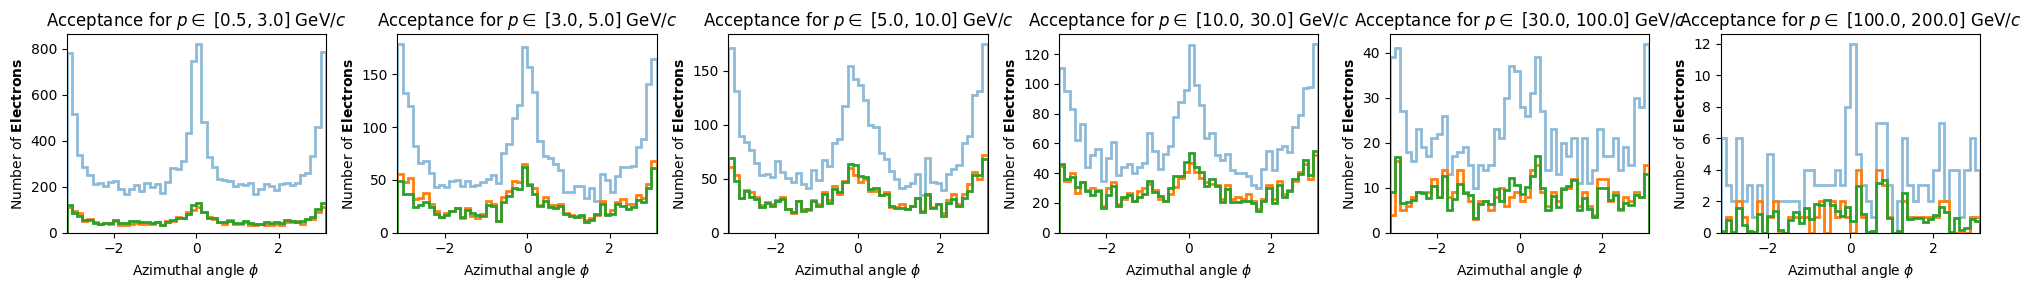

In [20]:
p_boundaries = [500, 3_000, 5_000, 10_000, 30_000, 100_000, 200_000]

for part in ['h', 'mu', 'e']:
    part_df = cdf.query(f"is_{part} and phi > -3.5 and phi < 3.5")[['acceptance', 'predicted', 'phi', 'log10_p']].compute()
    
    plt.figure(figsize=(20,3))
    for iPlot, (p_min, p_max) in enumerate(zip(p_boundaries[:-1], p_boundaries[1:]), 1):
        plt.subplot(1, len(p_boundaries)-1, iPlot)
        bin_df = part_df.query(f"log10_p > {np.log10(p_min)} and log10_p < {np.log10(p_max)}")
        denominator, bins = cp.histogram(bin_df.phi.values, bins=np.linspace(-np.pi, np.pi, 51))
        true_numerator, _ = cp.histogram(bin_df.query('acceptance').phi.values, bins=bins)
        pred_numerator,_ = cp.histogram(bin_df.phi.values, weights=bin_df.predicted.values, bins=bins)
    
        bins = bins.get()
        x = (bins[:-1] + bins[1:])/2
        plt.hist(x, bins=bins, weights=denominator.get(), histtype='step', linewidth=2, alpha=0.5, label="Generated")
        plt.hist(x, bins=bins, weights=true_numerator.get(), histtype='step', linewidth=2, label="In acceptance (true)")
        plt.hist(x, bins=bins, weights=pred_numerator.get(), histtype='step', linewidth=2, label="In acceptance (model)")
        plt.xlim(bins[0], bins[-1])

        part_name = dict(h="Hadrons", mu='Muons', e='Electrons')[part]
        plt.title(f"Acceptance for $p \in$ [{p_min/1e3:.1f}, {p_max/1e3:.1f}] GeV/$c$")
        plt.xlabel("Azimuthal angle $\phi$")
        plt.ylabel(f"Number of $\mathbf{{{part_name}}}$")
        plt.tight_layout()
    plt.show()